## LSTM with Upsampled Data and single label

In [1]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras import losses

/home/rr2n17/.conda/envs/myenv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# train = pd.read_csv('train.csv')
# test = pd.read_csv('test.csv')

In [3]:
identity = pd.read_json('IdentityOptimal.json')

In [4]:
identity.head()

,comment_text,identity_hate
0,"[agreed, addition, reds, give, angular, amplit...",0
1,"[Fischer, comments, attacks, added, quotations...",0
10,"[hey, Chris, wast, windpipe, six, ass, deleted...",0
100,"[authoritarian, little, hitless]",0
1000,"[editor, thermoformed, mod, administrator, win...",0


In [5]:
#test.head()

In [6]:
#To check for NULL values in training and test data
identity.isnull().any()

comment_text     False
identity_hate    False
dtype: bool

In [7]:
#the dependent variables are in the training set itself so we need to split them up, into X and Y sets.
#list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
list_classes = ["identity_hate"]
y = identity[list_classes].values
list_sentences_train = identity["comment_text"]
#list_sentences_test = test["comment_text"]

In [8]:
# to feed the comments into the LSTM as part of the neural network, these steps should be followed:
# 1) Tokenization - We need to break down the sentence into unique words. For eg, "I love cats and love dogs" will become ["I","love","cats","and","dogs"]
# 2) Indexing - We put the words in a dictionary-like structure and give them an index each For eg, {1:"I",2:"love",3:"cats",4:"and",5:"dogs"}
# 3) Index Representation- We could represent the sequence of words in the comments in the form of index, and feed this chain of index into our LSTM. For eg, [1,2,3,4,2,5]

In [9]:
max_features = 20000
tokenizer = Tokenizer(num_words = max_features)

In [10]:
tokenizer

In [11]:
tokenizer.fit_on_texts(list(list_sentences_train))

In [12]:
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
#list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)

In [13]:
list_tokenized_train[:1]

[[2054,
  1499,
  4735,
  100,
  14111,
  11829,
  3795,
  1403,
  418,
  18937,
  84,
  84,
  188,
  84,
  125,
  931,
  3646]]

In [14]:
#we have to feed a stream of data that has a consistent length(fixed number of features). Use padding for this.
#trim the longer sentences to the same length(maxlen) as the short ones. In this case, we have set the max length to be 200.
maxlen = 200
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
#X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

In [15]:
type(X_t)

numpy.ndarray

In [16]:
#to see distribution of words
totalNumWords = [len(one_comment) for one_comment in list_tokenized_train]

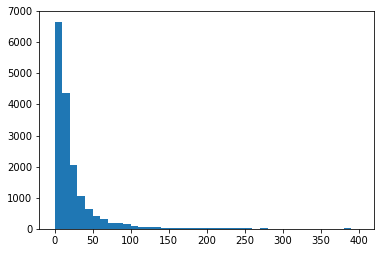

In [17]:
plt.hist(totalNumWords,bins = np.arange(0,410,10))#[0,50,100,150,200,250,300,350,400])#,450,500,550,600,650,700,750,800,850,900])
plt.show()
#output shows that most of the sentence length is about 30+

### Model

#### Input Layer

In [18]:
#the inputs into our networks are our list of encoded sentences.
#We begin defining an Input layer that accepts a list of sentences that has a dimension of 200.

In [19]:
inp = Input(shape=(maxlen, )) #maxlen=200 as defined earlier
#By indicating an empty space after comma, we are telling Keras to infer the number automatically

#### Embedding Layer

In [20]:
#here we project the words to a defined vector space depending on the distance of the surrounding words in a sentence
embed_size = 128
x = Embedding(max_features, embed_size)(inp)
#The output of the Embedding layer is just a list of the coordinates of the words in this vector space.
#For eg. (-81.012) for "cat" and (-80.012) for "dog".
#We could also use the distance of these coordinates to detect relevance and context. 

#### LSTM Layer

In [21]:
#We set the LSTM to produce an output that has a dimension of 60 and want it to return the whole unrolled sequence of results.
x = LSTM(60, return_sequences=True,name='lstm_layer')(x)

In [22]:
#the output is a tensor.
#To reshape 3D tensor to 2D, we use a Global Max Pooling layer which is traditionally used in CNN problems
#to reduce the dimensionality of image data

In [23]:
x = GlobalMaxPool1D()(x)

#### Dropout Layer

In [24]:
x = Dropout(0.1)(x)
#After a drop out layer, we connect the output of drop out layer to a densely connected layer
#and the output passes through a RELU function.

#Activation( (Input X Weights) + Bias)

In [25]:
x = Dense(50, activation="relu")(x) #define the Dense layer to produce an output dimension of 50

In [26]:
#Feed output into dropout layer again
x = Dropout(0.1)(x)

In [27]:
#Feed output to Sigmoid Layer
x = Dense(1, activation="sigmoid")(x)

In [28]:
# We have set our model to optimize our loss function using Adam optimizer, 
# define the loss function to be "binary_crossentropy" since we are tackling a binary classification.
# Default learning rate is set at 0.001.

In [32]:
model = Model(inputs=inp, outputs=x)
# model.compile(loss='binary_crossentropy',
#                   optimizer='adam',
#                   metrics=['accuracy'])
model.compile(loss='mean_squared_error',
                  optimizer='adam',
                  metrics=['accuracy'])

In [34]:
batch_size = 30
epochs = 2
model_result = model.fit(X_t,y, batch_size=batch_size, epochs=epochs, validation_split=0.2)

Train on 13488 samples, validate on 3372 samples
Epoch 1/2
13488/13488 [==============================] - 110s 8ms/step - loss: 0.0828 - acc: 0.8928 - val_loss: 0.0235 - val_acc: 0.9674
Epoch 2/2
13488/13488 [==============================] - 113s 8ms/step - loss: 0.0189 - acc: 0.9766 - val_loss: 0.0237 - val_acc: 0.9680


### Sequential Modelling

In [40]:
model = Sequential()
model.add(Dense(50, input_dim=200))
model.add(Activation('relu'))
model.add(Dense(1, input_dim=60))
model.add(Activation('sigmoid'))

In [41]:
y_pred = model.predict_proba(X_t)
print(y_pred)

[[0.0000000e+00]
 [0.0000000e+00]
 [1.0000000e+00]
 ...
 [1.0000000e+00]
 [9.9999988e-01]
 [1.0466949e-18]]


In [52]:
# len(X_t)
# len(y_pred)
difference = y_pred-y
#len(difference)
avg = np.average(difference)
avg

0.17383676450243005

In [49]:
#model.save('lstm_model_toxic.h5')

In [50]:
# from keras.models import load_model
# # load model from single file
# model = load_model('lstm_model_toxic.h5')
# # make predictions
# yhat = model.predict(X_t, verbose=0)
# print(yhat)